In [2]:
import pandas as pd
import requests
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import time 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sb

In [3]:
def get_user_animelist(username: str, client_id: str):
    # Loads list of anime from MAL for a given user
    url = f'https://api.myanimelist.net/v2/users/{username}/animelist?limit=500'
    headers = {
        'X-MAL-CLIENT-ID': client_id
    }
    params = {
        'fields': 'id, title, list_status{score,status}, start_season{year}, mean, genres, popularity, media_type, rating, num_episodes, studios, num_list_users,favorites'
    }

    all_data = []
    next_page = url

    while next_page:
        response = requests.get(next_page, headers=headers, params=params if next_page == url else None)
        if response.status_code != 200:
            raise ValueError(f"Error with API request: {response.status_code} - {response.text}")

        data = response.json()
        all_data.extend(data['data'])
        next_page = data.get("paging", {}).get("next")

        print(f"Loaded {len(all_data)} anime...")

    return all_data

In [4]:
def to_dataframe(all_data):
    rows = []
    for item in all_data:
        anime = item['node']
        score = item.get('list_status', {}).get('score')
        status = item.get('list_status', {}).get('status')
        # num_episodes_watched = item.get('list_status', {}).get('num_episodes_watched')
        year = item.get('node', {}).get('start_season', {}).get('year')
        rows.append({
            "id": anime['id'],
            "title": anime['title'],
            "mean": anime.get('mean'),
            "genres": [g['name'] for g in anime.get('genres', [])],
            "studios": [s['name'] for s in anime.get('studios', [])],
            "rating": anime.get('rating'),
            "year": year,
            "type": anime.get('media_type'),
            "popularity": anime.get('popularity'),
            "score": score,
            "status": status,
            "members": anime['num_list_users'],
            "num_episodes": anime['num_episodes'],
        })
    
    df = pd.DataFrame(rows)
    df['studios'] = df['studios'].str.join(", ")
    df['genres'] = df['genres'].str.join(", ")

    return df

In [5]:
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
USER_NAME = config.get('USER','USER_NAME').strip()
CLIENT_ID = config.get('USER','CLIENT_ID').strip()

In [6]:
data = get_user_animelist(USER_NAME, CLIENT_ID)

Loaded 500 anime...
Loaded 1000 anime...
Loaded 1500 anime...
Loaded 2000 anime...
Loaded 2500 anime...
Loaded 3000 anime...
Loaded 3500 anime...
Loaded 4000 anime...
Loaded 4500 anime...
Loaded 5000 anime...
Loaded 5054 anime...


In [7]:
df = to_dataframe(data)

In [8]:
df.tail(10)

,id,title,mean,genres,studios,rating,year,type,popularity,score,status,members,num_episodes
5044,3354,Zombie-Loan Specials,6.97,"Action, Horror, Shounen, Supernatural",XEBEC M2,pg_13,2008.0,special,4498,5,completed,29784,2
5045,37976,Zombieland Saga,7.50,"Award Winning, Comedy, Idols (Female), Music, ...",MAPPA,r,2018.0,tv,463,9,completed,523459,12
5046,50159,Zombieland Saga Movie: Yumeginga Paradise,NaN,"Comedy, Idols (Female), Music, Parody, Superna...",MAPPA,r,2025.0,movie,4244,0,plan_to_watch,33861,1
5047,40174,Zombieland Saga Revenge,7.99,"Comedy, Idols (Female), Music, Parody, Superna...",MAPPA,r,2021.0,tv,1163,8,completed,232665,12
5048,59421,Zutaboro Reijou wa Ane no Moto Konyakusha ni D...,7.36,"Drama, Josei, Romance",LandQ studios,pg_13,2025.0,tv,3619,5,completed,46193,12
5049,31245,Zutto Mae kara Suki deshita. Kokuhaku Jikkou I...,7.20,"Romance, School",Qualia Animation,pg_13,2016.0,movie,1077,5,completed,249699,1
5050,52034,[Oshi no Ko],8.56,"Award Winning, Drama, Reincarnation, Seinen, S...",Doga Kobo,pg_13,2023.0,tv,188,9,completed,983653,11
5051,55791,[Oshi no Ko] 2nd Season,8.55,"Drama, Reincarnation, Seinen, Showbiz",Doga Kobo,pg_13,2024.0,tv,532,8,completed,467947,13
5052,60058,[Oshi no Ko] 3rd Season,NaN,"Drama, Reincarnation, Seinen, Showbiz",Doga Kobo,pg_13,2026.0,tv,2077,0,plan_to_watch,117529,0
5053,1692,_Summer,5.55,"Drama, Harem, Romance",Rikuentai,pg_13,2006.0,ova,6682,2,completed,11199,2


In [9]:
df["studios"].replace(to_replace="", value="Unknown", inplace=True)
df["genres"].replace(to_replace="", value="Unknown", inplace=True)
df = df.dropna(subset=['score'])

C:\Users\dobre\AppData\Local\Temp\ipykernel_9212\87429005.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["studios"].replace(to_replace="", value="Unknown", inplace=True)
C:\Users\dobre\AppData\Local\Temp\ipykernel_9212\87429005.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [10]:
display(df["score"].value_counts().head(11))

score
0     1329
5      793
7      756
6      574
8      517
4      434
3      350
9      151
2      114
10      25
1       11
Name: count, dtype: int64

In [11]:
df.drop(columns=['title'], inplace=True)

In [12]:
df = df[df['score'] > 0].copy()
    
df['mean'] = df['mean'].fillna(df.groupby('type')['mean'].transform('median'))
    
categorical_cols = ['type', 'rating', 'status']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [13]:
df['year'] = df['year'].fillna(df['year'].mode()[0])
df['num_episodes'] = df['num_episodes'].fillna(df['num_episodes'].mode()[0])

In [14]:
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

In [15]:
df['anime_age'] = 2025 - df['year']
df['anime_age'] = df['anime_age'].astype(int)
df.drop(columns=['year'], inplace=True)

In [16]:
df['is_masterpiece'] = (
    (df['mean'] >= 8.8) * 0.5 +                 
    (df['popularity'] <= 250) * 0.4 +   
    (df['num_episodes'] >= 12) * 0.1  
)

In [17]:
df['log_members'] = np.log1p(df['members'])
df.drop(columns=['id', 'members'], inplace=True)

In [18]:
# Get dummy variables for each unique genre
genre_dummies = (
    df['genres']
    .str.split(', ', expand=True) 
    .stack()       
    .str.get_dummies()         
    .groupby(level=0)         
    .sum()                    
    .add_prefix('Genre_')  
)

df.drop(columns=['genres'], inplace=True)

In [19]:
df = pd.concat([df, genre_dummies], axis=1)

In [20]:
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
print(genre_counts)

Genre_Action         1480
Genre_Comedy         1335
Genre_Fantasy         996
Genre_School          918
Genre_Romance         871
                     ... 
Genre_Educational       6
Genre_Hentai            2
Genre_Boys Love         2
Genre_Erotica           2
Genre_Unknown           1
Length: 79, dtype: int64


In [21]:
top_genres = genre_counts.nlargest(40).index

other_genres = [col for col in genre_columns if col not in top_genres]
df['Genre_Other'] = df[other_genres].max(axis=1)
df.drop(columns=other_genres, inplace=True)

In [22]:
type_dummies = pd.get_dummies(df['type'], prefix='Type')
df = pd.concat([df, type_dummies], axis=1)
df.drop(columns=['type'], inplace=True)

In [23]:
top_studios = df['studios'].value_counts().nlargest(10).index
print(top_studios)

Index(['J.C.Staff', 'A-1 Pictures', 'Madhouse', 'Studio Deen', 'Sunrise',
       'Production I.G', 'Bones', 'SILVER LINK.', 'Gonzo', 'Toei Animation'],
      dtype='object', name='studios')


In [24]:
df['studios'] = df['studios'].apply(lambda x: x if x in top_studios else 'Studios_Other')

In [25]:
studio_dummies = pd.get_dummies(df['studios'], prefix='Studio')
df = pd.concat([df, studio_dummies], axis=1)
df.drop(columns=['studios'], inplace=True)

In [26]:
rating_dummies = pd.get_dummies(df['rating'], prefix='Rating')
df = pd.concat([df, rating_dummies], axis=1)
df.drop(columns=['rating'], inplace=True)

In [27]:
status_dummies = pd.get_dummies(df['status'], prefix='Status')
df = pd.concat([df, status_dummies], axis=1)
df.drop(columns=['status'], inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3725 entries, 1 to 5053
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mean                   3725 non-null   float64
 1   popularity             3725 non-null   int64  
 2   score                  3725 non-null   int64  
 3   num_episodes           3725 non-null   int64  
 4   anime_age              3725 non-null   int32  
 5   is_masterpiece         3725 non-null   float64
 6   log_members            3725 non-null   float64
 7   Genre_Action           3725 non-null   int64  
 8   Genre_Adult Cast       3725 non-null   int64  
 9   Genre_Adventure        3725 non-null   int64  
 10  Genre_Award Winning    3725 non-null   int64  
 11  Genre_CGDCT            3725 non-null   int64  
 12  Genre_Comedy           3725 non-null   int64  
 13  Genre_Detective        3725 non-null   int64  
 14  Genre_Drama            3725 non-null   int64  
 15  Genre_Ecc

In [29]:
bool_cols = df.select_dtypes('bool').columns

df[bool_cols] = df[bool_cols].astype(int)

In [30]:
df.drop(columns=['Type_Unknown', 'Studio_Unknown'], inplace=True)

KeyError: "['Type_Unknown', 'Studio_Unknown'] not found in axis"

In [31]:
correlation = df['mean'].corr(df['score'])
print(correlation)

0.6884417989366609


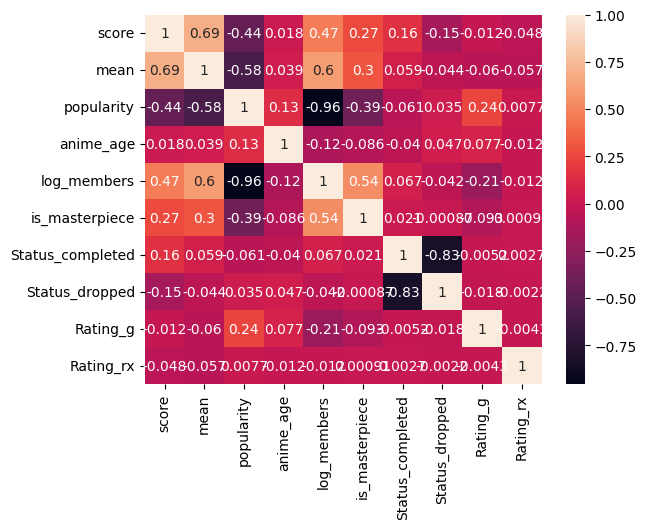

In [35]:
corr_cols = ['score', 'mean', 'popularity', 'anime_age', 
             'log_members', 'is_masterpiece', 
             'Status_completed', 'Status_dropped', 
             'Rating_g', 'Rating_rx']

corr_matrix = df[corr_cols].corr()
sb.heatmap(corr_matrix, annot=True)
plt.show()

In [38]:
corr_with_score = df.corr()['score']
high_corr_cols = corr_with_score[np.abs(corr_with_score) > 0.65].index
high_corr_cols = high_corr_cols.drop('score')
print(high_corr_cols)

Index(['mean'], dtype='object')


In [39]:
df.drop(columns=high_corr_cols, inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3725 entries, 1 to 5053
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   popularity             3725 non-null   int64  
 1   score                  3725 non-null   int64  
 2   num_episodes           3725 non-null   int64  
 3   anime_age              3725 non-null   int32  
 4   is_masterpiece         3725 non-null   float64
 5   log_members            3725 non-null   float64
 6   Genre_Action           3725 non-null   int64  
 7   Genre_Adult Cast       3725 non-null   int64  
 8   Genre_Adventure        3725 non-null   int64  
 9   Genre_Award Winning    3725 non-null   int64  
 10  Genre_CGDCT            3725 non-null   int64  
 11  Genre_Comedy           3725 non-null   int64  
 12  Genre_Detective        3725 non-null   int64  
 13  Genre_Drama            3725 non-null   int64  
 14  Genre_Ecchi            3725 non-null   int64  
 15  Genre_Fan

In [41]:
df['num_episodes'] = np.log1p(df['num_episodes'])
df.drop(columns=['popularity'], inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3725 entries, 1 to 5053
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   score                  3725 non-null   int64  
 1   num_episodes           3725 non-null   float64
 2   anime_age              3725 non-null   int32  
 3   is_masterpiece         3725 non-null   float64
 4   log_members            3725 non-null   float64
 5   Genre_Action           3725 non-null   int64  
 6   Genre_Adult Cast       3725 non-null   int64  
 7   Genre_Adventure        3725 non-null   int64  
 8   Genre_Award Winning    3725 non-null   int64  
 9   Genre_CGDCT            3725 non-null   int64  
 10  Genre_Comedy           3725 non-null   int64  
 11  Genre_Detective        3725 non-null   int64  
 12  Genre_Drama            3725 non-null   int64  
 13  Genre_Ecchi            3725 non-null   int64  
 14  Genre_Fantasy          3725 non-null   int64  
 15  Genre_Gag

In [43]:
X = df.drop(columns=['score'])
y = df['score']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [45]:
# balancing
sample_weights = compute_sample_weight('balanced', y_train.astype(int))

In [46]:
model_weighted = RandomForestRegressor(n_estimators=200, random_state=42 )
model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

RandomForestRegressor(n_estimators=200, random_state=42)

In [47]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [48]:
y_pred_weight = model_weighted.predict(X_test)
y_pred = model.predict(X_test)

In [49]:
def comprehensive_evaluation(y_true, y_pred):
    """complex evaluation"""
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    accuracy_05 = np.mean(np.abs(y_true - y_pred) <= 0.5)
    accuracy_1 = np.mean(np.abs(y_true - y_pred) <= 1.0)
    accuracy_15 = np.mean(np.abs(y_true - y_pred) <= 1.5)
    
    score_metrics = {}
    for score in range(1, 11):
        mask = (y_true == score)
        if mask.sum() > 0:
            score_mae = mean_absolute_error(y_true[mask], y_pred[mask])
            score_metrics[f'MAE_score_{score}'] = score_mae
    
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    return {
        'MAE': mae,
        'MSE': mse, 
        'RMSE': rmse,
        'R2': r2,
        'Correlation': correlation,
        'Accuracy_±0.5': accuracy_05,
        'Accuracy_±1.0': accuracy_1,
        'Accuracy_±1.5': accuracy_15,
        **score_metrics
    }


In [50]:
results = comprehensive_evaluation(y_test, y_pred)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

MAE: 1.111
MSE: 1.952
RMSE: 1.397
R2: 0.401
Correlation: 0.634
Accuracy_±0.5: 0.275
Accuracy_±1.0: 0.533
Accuracy_±1.5: 0.717
MAE_score_1: 3.500
MAE_score_2: 2.050
MAE_score_3: 1.849
MAE_score_4: 1.079
MAE_score_5: 0.823
MAE_score_6: 0.821
MAE_score_7: 0.866
MAE_score_8: 1.335
MAE_score_9: 1.636
MAE_score_10: 1.522


In [51]:
print("Weighted")
results = comprehensive_evaluation(y_test, y_pred_weight)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

Weighted
MAE: 1.110
MSE: 1.913
RMSE: 1.383
R2: 0.412
Correlation: 0.643
Accuracy_±0.5: 0.281
Accuracy_±1.0: 0.533
Accuracy_±1.5: 0.722
MAE_score_1: 3.452
MAE_score_2: 2.003
MAE_score_3: 1.796
MAE_score_4: 1.109
MAE_score_5: 0.810
MAE_score_6: 0.839
MAE_score_7: 0.876
MAE_score_8: 1.348
MAE_score_9: 1.596
MAE_score_10: 1.499


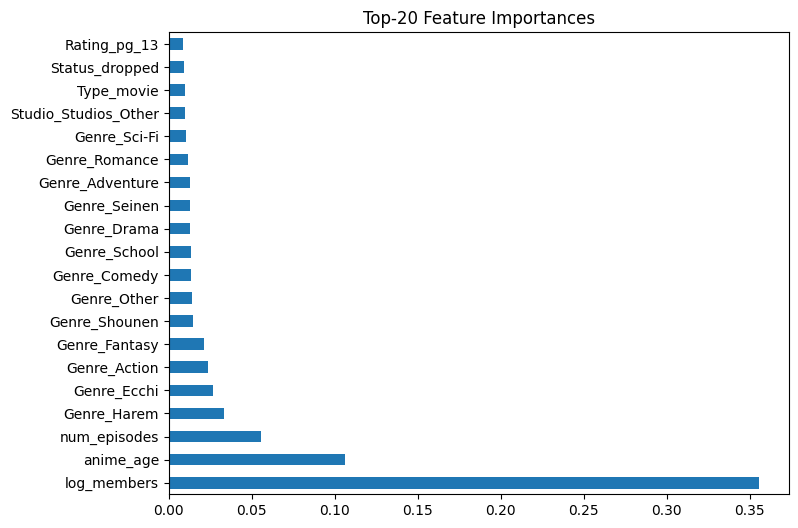

In [52]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title("Top-20 Feature Importances")
plt.show()